In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [19]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 53.4 MB/s eta 0:00:00


In [4]:
!pip install wxee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 6.3 MB/s eta 0:00:00


In [2]:
# !earthengine authenticate
import ee
import os

# Set the path to the service account key file
service_account = 'editor@ee-manmeet20singh15-wbis.iam.gserviceaccount.com'
key_file = 'drive/MyDrive/earth_engine/ee-manmeet20singh15-wbis-fab7f1ca35e0.json'

# Use the service account for authentication
credentials = ee.ServiceAccountCredentials(service_account, key_file)
ee.Initialize(credentials)

In [5]:
import ee
import wxee
#wxee.Initialize()

In [7]:
from geopy.geocoders import Nominatim
from pyproj import CRS
# import utm
#import proj
import pandas as pd
import numpy as np

In [8]:
import ee

# Define the bounding box coordinates for CONUS
lat_diff = 0
lon_diff = 0

aoi = ee.Geometry.Polygon([
    [[-125.0 - lon_diff, 24.5 - lat_diff],  # Bottom-left
     [-66.9 + lon_diff, 24.5 - lat_diff],  # Bottom-right
     [-66.9 + lon_diff, 49.4 + lat_diff],  # Top-right
     [-125.0 - lon_diff, 49.4 + lat_diff]] # Top-left
])

# Print to check
print(aoi.getInfo())


{'type': 'Polygon', 'coordinates': [[[-125, 24.5], [-66.9, 24.5], [-66.9, 49.4], [-125, 49.4], [-125, 24.5]]]}


In [12]:
start_date = '2022-01-01'
end_date = '2022-01-30'

dataset = ee.ImageCollection('NASA/GSFC/MERRA/slv/2').filter(ee.Filter.date(start_date, end_date)).select('TS').mean()

In [14]:
dataset = dataset.set('system:time_start', 0)
ds = dataset.wx.to_xarray(region=aoi.bounds(), scale=55000)#,  crs='EPSG:32645')

Downloading:   0%|          | 0.00/19.0k [00:00<?, ?iB/s]

In [17]:
ds

<xarray.Dataset> Size: 29kB
Dimensions:      (time: 1, x: 118, y: 59)
Coordinates:
  * time         (time) datetime64[ns] 8B 1970-01-01
  * x            (x) float64 944B -124.8 -124.3 -123.8 ... -67.94 -67.44 -66.95
  * y            (y) float64 472B 53.11 52.62 52.12 51.63 ... 25.44 24.95 24.46
    spatial_ref  int64 8B 0
Data variables:
    TS           (time, y, x) float32 28kB 264.6 264.6 264.1 ... 299.0 298.8
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

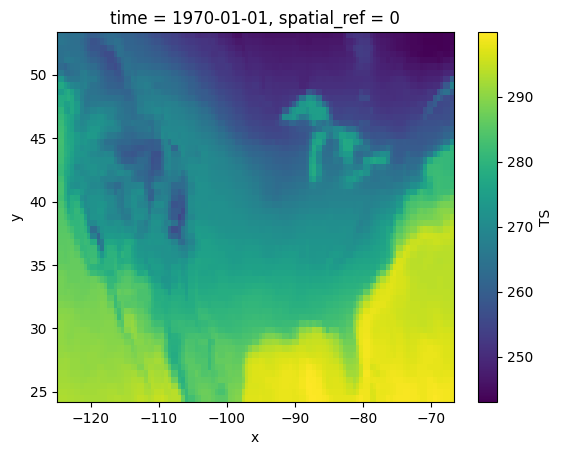

In [16]:
ds.TS.plot()

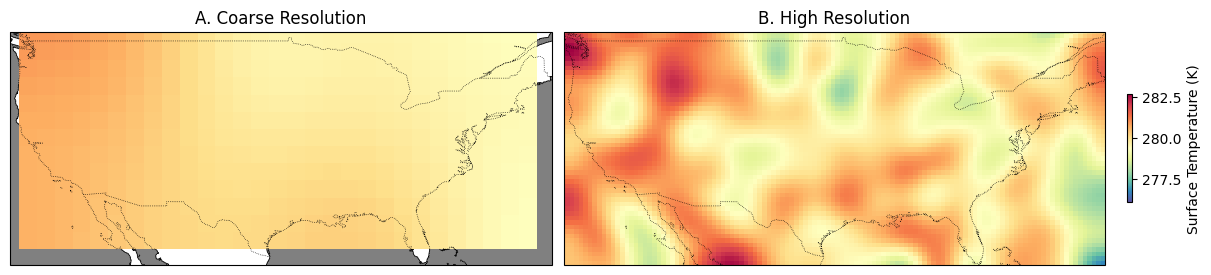

In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
from scipy.ndimage import gaussian_filter

# Apply Gaussian smoothing
smoothed_TS = gaussian_filter(ds.TS.mean(dim='time'), sigma=4)
smoothed_TS_coarse = gaussian_filter(ds_coarse.TS.mean(dim='time'), sigma=4)  # Keep Gaussian filter

# Define figure and axes with Cartopy projection
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True,
                         subplot_kw={"projection": ccrs.PlateCarree()})

# Define colormap
cmap = "Spectral_r"  # Better contrast for temperature data

# Set color limits based on both datasets
vmin = min(smoothed_TS.min(), smoothed_TS_coarse.min())
vmax = max(smoothed_TS.max(), smoothed_TS_coarse.max())

# Plot coarsened data
im2 = axes[0].imshow(smoothed_TS_coarse, cmap=cmap, vmin=vmin, vmax=vmax,
                     extent=[ds_coarse.x.min(), ds_coarse.x.max(), ds_coarse.y.min(), ds_coarse.y.max()],
                     origin="upper", transform=ccrs.PlateCarree())

# Plot original high-resolution data
im1 = axes[1].imshow(smoothed_TS, cmap=cmap, vmin=vmin, vmax=vmax,
                     extent=[ds.x.min(), ds.x.max(), ds.y.min(), ds.y.max()],
                     origin="upper", transform=ccrs.PlateCarree())

# Add features to maps
for ax in axes:
    ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black")
    ax.add_feature(cfeature.OCEAN, facecolor="gray")  # Ocean masked in gray
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linestyle=":", linewidth=0.5)
    ax.set_extent([-125, -67, 25, 50], crs=ccrs.PlateCarree())  # Set extent to CONUS

axes[0].set_title("A. Coarse Resolution")
axes[1].set_title("B. High Resolution")

# plt.colorbar(im1, ax=axes[1], orientation="vertical", fraction=0.046, pad=0.04)
plt.colorbar(im1, ax=axes[1], orientation="vertical", fraction=0.01, pad=0.04, label='Surface Temperature (K)')


plt.show()
